In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
ar_data=pd.read_pickle(r'ar.pickle')

In [5]:
ar_data.keys()

dict_keys(['language', 'envelope', 'sampling frequency', 'stimuli names'])

In [8]:
ar_data['language']

'ar'

In [ ]:
ar_data['envelope'].shape
# this is 7224 clips of 3-second clips that are sampled at 512 Hz

(7224, 1536)

In [9]:
ar_data['stimuli names']

array(['A01___01_Genesis_____ARBWTCO1DA__1.wav',
       'A01___01_Genesis_____ARBWTCO1DA__10.wav',
       'A01___01_Genesis_____ARBWTCO1DA__100.wav', ...,
       'A02___05_Exodus______ARBWTCO1DA__97.wav',
       'A02___05_Exodus______ARBWTCO1DA__98.wav',
       'A02___05_Exodus______ARBWTCO1DA__99.wav'], dtype='<U40')

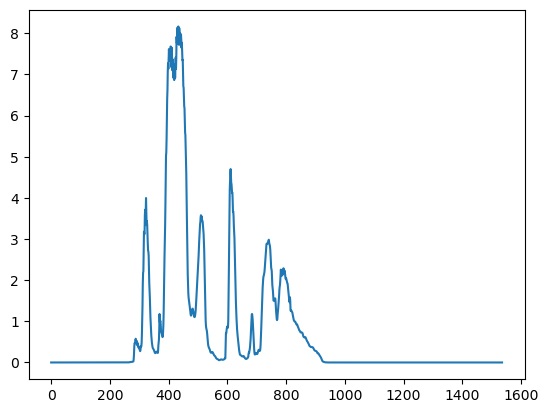

In [ ]:
# visualize data
plt.plot(ar_data['envelope'][0])

In [ ]:
ar_data=pd.read_pickle(r'ar.pickle')['envelope']

TypeError: 'tuple' object is not callable

In [20]:
ar_data.shape[0]

7224

In [23]:
ar_tensor = torch.tensor(ar_data)
ar_tensor[0,:]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.0183e-57, 3.9975e-57,
        1.9686e-57], dtype=torch.float64)

In [21]:
ar_data[0,:]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       4.01833163e-57, 3.99753562e-57, 1.96862391e-57])

In [24]:
A = ['ar', 'en', 'es']
A.index('ar')

0

In [38]:
tensor = torch.zeros(3,1,1)
tensor[0,0,0] = 1.0
tensor

tensor([[[1.]],

        [[0.]],

        [[0.]]])

In [42]:
tensor = torch.tensor(np.array([1,2,3]))
tensor

tensor([1, 2, 3], dtype=torch.int32)

In [52]:
tensor.unsqueeze(-1)

tensor([[1],
        [2],
        [3]], dtype=torch.int32)

In [ ]:
from io import open
import glob
import os
import time

import torch
from torch.utils.data import Dataset
n_speech = 3*512

class SpeechDataset(Dataset):

    def __init__(self):
        self.load_time = time.localtime #for provenance of the dataset
        labels_set = set() #set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        ar_data=pd.read_pickle(r'ar.pickle')['envelope']
        en_data=pd.read_pickle(r'en.pickle')['envelope']
        es_data=pd.read_pickle(r'es.pickle')['envelope']
        labels_set = ['ar','en','es']
        # ar
        for j in range(ar_data.shape[0]):
            data = ar_data[j,:]
            self.data.append(data)
            self.data_tensors.append(torch.tensor(data,dtype=torch.float32).unsqueeze(-1).unsqueeze(-1)) 
            # so we get nspeech x 1 X 1 tensor (batch of 1 and feature (ninput) of 1)
            # pytorch prefers float32 because that's what gpu is run on
            self.labels.append('ar')
        # en
        for j in range(en_data.shape[0]):
            data = en_data[j,:]
            self.data.append(data)
            self.data_tensors.append(torch.tensor(data,dtype=torch.float32).unsqueeze(-1).unsqueeze(-1))
            self.labels.append('en')
        # es
        for j in range(es_data.shape[0]):
            data = es_data[j,:]
            self.data.append(data)
            self.data_tensors.append(torch.tensor(data,dtype=torch.float32).unsqueeze(-1).unsqueeze(-1))
            self.labels.append('es')

        #Cache the tensor representation of the labels
        self.labels_list = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_list.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [59]:
alldata = SpeechDataset()
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20069 items of data
example = (tensor([0]), tensor([[[0.0000e+00]],

        [[0.0000e+00]],

        [[0.0000e+00]],

        ...,

        [[4.0183e-57]],

        [[3.9975e-57]],

        [[1.9686e-57]]], dtype=torch.float64), 'ar', array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       4.01833163e-57, 3.99753562e-57, 1.96862391e-57]))


In [55]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15])

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17059, validation examples = 3010


In [56]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output


In [57]:
n_hidden = 128
n_input = 1 # 1D array
rnn = CharRNN(n_input, n_hidden, len(alldata.labels_list)) 
# output is vector of length 3 (number of languages), and the softmax gives probability of each language
# the most probable one is chosen as the label

In [61]:
# predictor function
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input = torch.tensor(ar_data[0,:]).unsqueeze(-1).unsqueeze(-1)
output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_list))

ValueError: input must have the type torch.float32, got type torch.float64

In [ ]:
import random
import numpy as np

def train(rnn, training_data, n_epoch = 10, n_batch_size = 64, report_every = 50, learning_rate = 0.2, criterion = nn.NLLLoss()):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    start = time.time()
    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) //n_batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

In [ ]:
start = time.time()
all_losses = train(rnn, train_set, n_epoch=27, learning_rate=0.15, report_every=5)
end = time.time()
print(f"training took {end-start}s")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()